## EDA analysis for *Anonymized Implementation Tickets Dataset (anonymized_hubspot_tickets.csv)*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
path = "/Users/annalorenz/Documents/Uni/Vanderbilt/02_Courses/spring2025/Machine_learning/project/data/anonymized_hubspot_tickets.csv"
df = pd.read_csv(path)

## Step 1: Data Cleaning 

In [3]:
print("\n Dataset Overview:")
print(df.info())


 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 46 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Create date                                    79 non-null     object 
 1   Ticket Tags                                    0 non-null      float64
 2   Stage Date - Project Launch                    31 non-null     object 
 3   Associated Contact                             78 non-null     object 
 4   Category                                       0 non-null      float64
 5   Target Launch Date                             29 non-null     object 
 6   Kickoff Call                                   49 non-null     object 
 7   Close date                                     55 non-null     object 
 8   Pipeline                                       79 non-null     object 
 9   Stage Date - Project Initiation     

In [4]:
df.columns

Index(['Create date', 'Ticket Tags', 'Stage Date - Project Launch',
       'Associated Contact', 'Category', 'Target Launch Date', 'Kickoff Call',
       'Close date', 'Pipeline', 'Stage Date - Project Initiation',
       'Stage Date - Planning Phase', 'Ticket status',
       'Stage Date - Execution', 'Time to first agent email reply (HH:mm:ss)',
       'Last CES survey rating', 'Priority', 'Associated Company',
       'Who will be creating the Syms?', 'Stage Date - Closure Phase',
       'Stage Date - Monitoring and Control Phase',
       'Associated Company (Primary)', 'Response time (HH:mm:ss)', 'Ticket ID',
       'Time to close (HH:mm:ss)', 'Associated Deal', 'Library index approved',
       'Training: General Overview', 'Latest Milestone',
       'Training: Deployment/User Management Training',
       'Requirements for the Trial', 'Training: Sym Building 101',
       'Last modified date', 'Type', 'Trial End Date',
       'Training: Sym Building 201', 'Stage Date - Converted Won',

### This block performs data cleaning by removing columns with over 80% missing or zero values. It then fills missing values using the mode for categorical features and the median for numeric ones


In [5]:
# Remove columns with more than 80% missing data or 0 entries 
threshold = 0.8
df_cleaned = df.loc[:, df.isnull().mean() < threshold].copy()

zero_threshold = 0.8
num_columns = df_cleaned.select_dtypes(include=[np.number]).columns
cols_to_drop = [col for col in num_columns if (df[col] == 0).mean() > zero_threshold]
df_cleaned = df_cleaned.drop(columns=cols_to_drop)

num_columns = df_cleaned.select_dtypes(include=[np.number]).columns

cat_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:
    mode_value = df_cleaned[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].fillna(mode_value)

for col in num_columns:
    median_value = df[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)

print("DataFrame shape after cleaning:", df_cleaned.shape)
print(df_cleaned.info())

DataFrame shape after cleaning: (79, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Create date                                    79 non-null     object
 1   Stage Date - Project Launch                    79 non-null     object
 2   Associated Contact                             79 non-null     object
 3   Target Launch Date                             79 non-null     object
 4   Kickoff Call                                   79 non-null     object
 5   Close date                                     79 non-null     object
 6   Pipeline                                       79 non-null     object
 7   Stage Date - Project Initiation                79 non-null     object
 8   Ticket status                                  79 non-null     object
 9   Stage Date - Execution    

### This step converts date columns to the datetime format 

In [6]:
# Convert date columns to datetime format
date_cols = ['Create date', 
             'Stage Date - Project Launch', 
             'Target Launch Date', 
             'Kickoff Call', 
             'Close date', 
             'Stage Date - Project Initiation', 
             'Stage Date - Execution', 
             'Stage Date - Closure Phase', 
             'Stage Date - Converted Won', 
             'Latest Milestone Update Date', 
             'Training: Deployment/User Management Training',
             'Training: Sym Building 101',
             'Training: Sym Building 201',
             'Training: General Overview',
             'Trial Start Date', 
             'Trial End Date',
             '1st Syms presented for review', 
             'Project Launch Day', 
             'Training: Reporting', 
             'Construction of 1st Sym begun', 
             'Last modified date']
for col in date_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')


In [7]:
# Convert time variables to numeric
time_cols = ['Time to first agent email reply (HH:mm:ss)', 'Time to close (HH:mm:ss)', 'Response time (HH:mm:ss)']

for col in time_cols:
    df_cleaned[col] = pd.to_timedelta(df_cleaned[col], errors='coerce')


### This step creates a new feature duration by calculating the number of days between Create Date and Last Modified Date

In [8]:
# Feature Engineering
df_cleaned['duration'] = (df_cleaned['Last modified date'] - df_cleaned['Create date']).dt.days

print("\n'duration' feature sample values:")
print(df_cleaned['duration'].head())
print(df_cleaned.info())


'duration' feature sample values:
0    423
1    107
2     64
3    525
4      3
Name: duration, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   Create date                                    79 non-null     datetime64[ns] 
 1   Stage Date - Project Launch                    79 non-null     datetime64[ns] 
 2   Associated Contact                             79 non-null     object         
 3   Target Launch Date                             79 non-null     datetime64[ns] 
 4   Kickoff Call                                   79 non-null     datetime64[ns] 
 5   Close date                                     79 non-null     datetime64[ns] 
 6   Pipeline                                       79 non-null     object         
 7   Stage Date - Project Initia

In [9]:
# Convert Ticket ID to categorical variable
df_cleaned['Ticket ID'] = df_cleaned['Ticket ID'].astype('category')

### This step handles outliers in numeric columns by applying the IQR method and capping extreme values at the lower and upper bounds

In [10]:
print(df_cleaned.isnull().sum())

Create date                                      0
Stage Date - Project Launch                      0
Associated Contact                               0
Target Launch Date                               0
Kickoff Call                                     0
Close date                                       0
Pipeline                                         0
Stage Date - Project Initiation                  0
Ticket status                                    0
Stage Date - Execution                           0
Time to first agent email reply (HH:mm:ss)       0
Associated Company                               0
Stage Date - Closure Phase                       0
Associated Company (Primary)                     0
Response time (HH:mm:ss)                         0
Ticket ID                                        0
Time to close (HH:mm:ss)                         0
Associated Deal                                  0
Library index approved                           0
Training: General Overview     

In [11]:
# Missing values
missing_values = df_cleaned.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df_cleaned)) * 100
df_missing = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
display(df_missing[df_missing['Missing Values'] > 0])

,Missing Values,Percentage


In [12]:
num_columns = df_cleaned.select_dtypes(include=[np.number]).columns
time_like_columns = df_cleaned.select_dtypes(include=['timedelta64[ns]', 'datetime64[ns]']).columns
num_columns = [col for col in num_columns if col not in time_like_columns]

# Outlier Handling
for col in num_columns:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col])
    df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])

print(df_cleaned.shape)
print(df_cleaned.columns)

(79, 37)
Index(['Create date', 'Stage Date - Project Launch', 'Associated Contact',
       'Target Launch Date', 'Kickoff Call', 'Close date', 'Pipeline',
       'Stage Date - Project Initiation', 'Ticket status',
       'Stage Date - Execution', 'Time to first agent email reply (HH:mm:ss)',
       'Associated Company', 'Stage Date - Closure Phase',
       'Associated Company (Primary)', 'Response time (HH:mm:ss)', 'Ticket ID',
       'Time to close (HH:mm:ss)', 'Associated Deal', 'Library index approved',
       'Training: General Overview', 'Latest Milestone',
       'Training: Deployment/User Management Training',
       'Requirements for the Trial', 'Training: Sym Building 101',
       'Last modified date', 'Trial End Date', 'Training: Sym Building 201',
       'Stage Date - Converted Won', 'Latest Milestone Update Date',
       'Ticket name', 'Trial Overview', 'Trial Start Date',
       '1st Syms presented for review', 'Project Launch Day',
       'Training: Reporting', 'Construct

## Step 2: Exploratory Data Analysis (EDA) 

### Class distribution

In [13]:
for col in cat_columns:
    print(f"\nValue counts for '{col}':")
    print(df_cleaned[col].value_counts())


Value counts for 'Create date':
Create date
2023-12-18 15:02:00    1
2024-04-01 19:36:00    1
2024-01-02 09:21:00    1
2024-04-03 08:24:00    1
2024-04-03 08:25:00    1
                      ..
2023-11-08 12:59:00    1
2023-11-06 10:51:00    1
2024-06-09 22:48:00    1
2024-08-23 11:27:00    1
2024-09-23 08:24:00    1
Name: count, Length: 79, dtype: int64

Value counts for 'Stage Date - Project Launch':
Stage Date - Project Launch
2023-12-14    51
2024-06-21     2
2024-08-21     2
2024-12-24     1
2024-04-14     1
2024-09-26     1
2024-02-14     1
2024-12-13     1
2024-11-19     1
2024-08-15     1
2024-03-19     1
2024-05-13     1
2024-03-27     1
2023-12-08     1
2024-07-21     1
2025-01-10     1
2024-08-23     1
2024-09-13     1
2024-05-22     1
2024-04-02     1
2023-12-27     1
2024-10-10     1
2024-08-08     1
2023-12-18     1
2024-10-15     1
2024-10-04     1
2025-01-13     1
Name: count, dtype: int64

Value counts for 'Associated Contact':
Associated Contact
Contact_80789466    3

### Summary Statistics

In [14]:
display(df_cleaned.describe(include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Create date,79,NaN,NaN,NaN,2024-05-31 12:48:44.050633216,2023-06-01 15:14:00,2024-01-24 11:42:00,2024-06-09 22:48:00,2024-11-09 22:37:00,2025-02-19 14:45:00,NaN
Stage Date - Project Launch,79,NaN,NaN,NaN,2024-02-27 19:08:21.265822720,2023-12-08 00:00:00,2023-12-14 00:00:00,2023-12-14 00:00:00,2024-04-28 12:00:00,2025-01-13 00:00:00,NaN
Associated Contact,79,74,Contact_80789466,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Target Launch Date,79,NaN,NaN,NaN,2023-10-23 20:39:29.620253184,2023-09-02 00:00:00,2023-09-08 00:00:00,2023-09-08 00:00:00,2023-10-09 12:00:00,2024-07-08 00:00:00,NaN
Kickoff Call,79,NaN,NaN,NaN,2024-06-04 20:21:15.949367040,2023-01-11 00:00:00,2024-04-07 00:00:00,2024-08-13 00:00:00,2024-08-13 00:00:00,2025-02-11 00:00:00,NaN
Close date,79,NaN,NaN,NaN,2024-06-22 15:09:34.936708864,2023-10-24 10:51:00,2024-04-30 10:56:00,2024-04-30 10:56:00,2024-09-20 10:27:00,2025-02-12 15:20:00,NaN
Pipeline,79,1,Project Success Plan,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stage Date - Project Initiation,79,NaN,NaN,NaN,2024-07-04 16:42:31.898734080,2023-12-05 00:00:00,2024-04-01 00:00:00,2024-05-20 00:00:00,2024-11-02 12:00:00,2025-02-19 00:00:00,NaN
Ticket status,79,8,Converted-Won,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stage Date - Execution,79,NaN,NaN,NaN,2024-08-01 06:04:33.417721600,2023-12-05 00:00:00,2024-07-19 00:00:00,2024-07-19 00:00:00,2024-08-08 12:00:00,2025-02-19 00:00:00,NaN


### Feature correlations for numeric variables

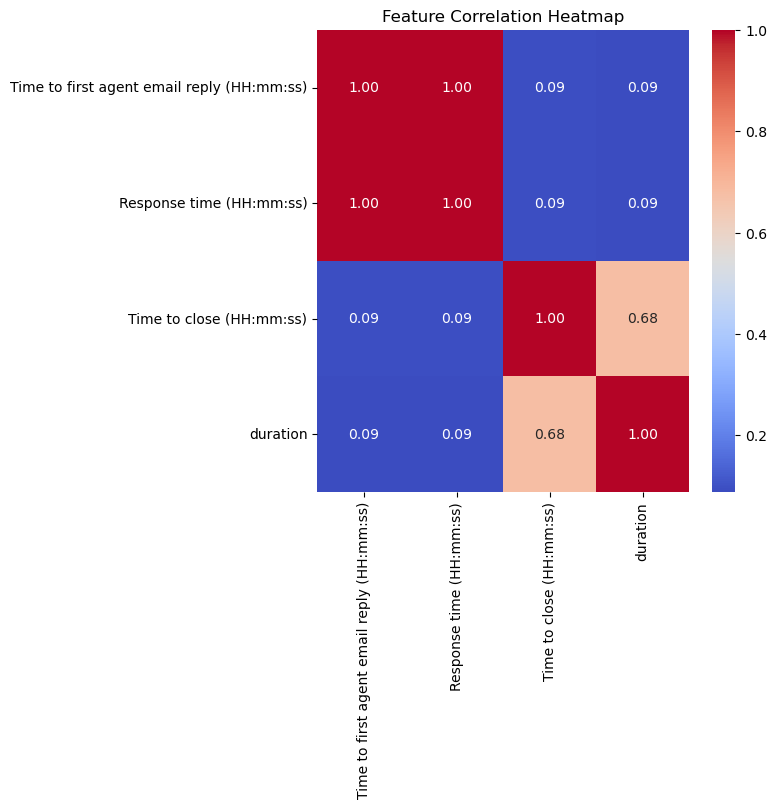

In [15]:
# Feature correlation heatmap (not very meaningful because no numerical variables)
num_columns = df_cleaned.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(6,6))
sns.heatmap(df_cleaned[num_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

This dataset does not contain numerical variables other than time variables and created variables. There the correlation heatmap should be interpreted with caution. 

### Data visualizations 

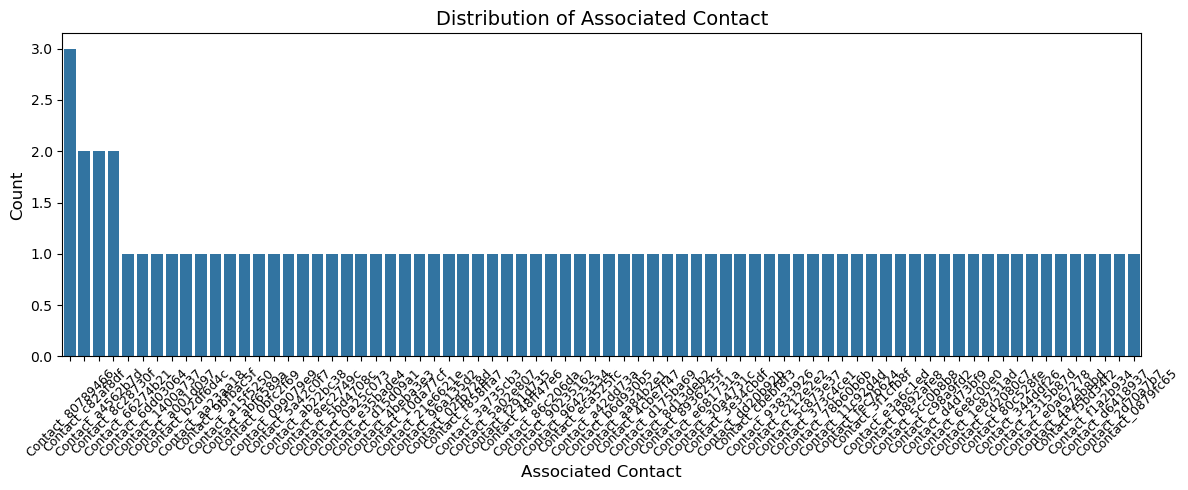

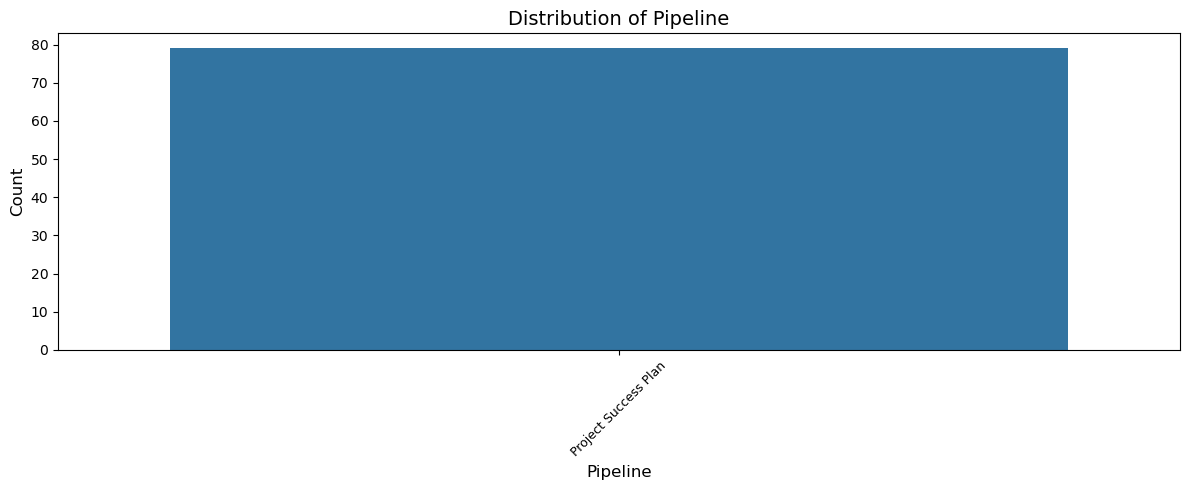

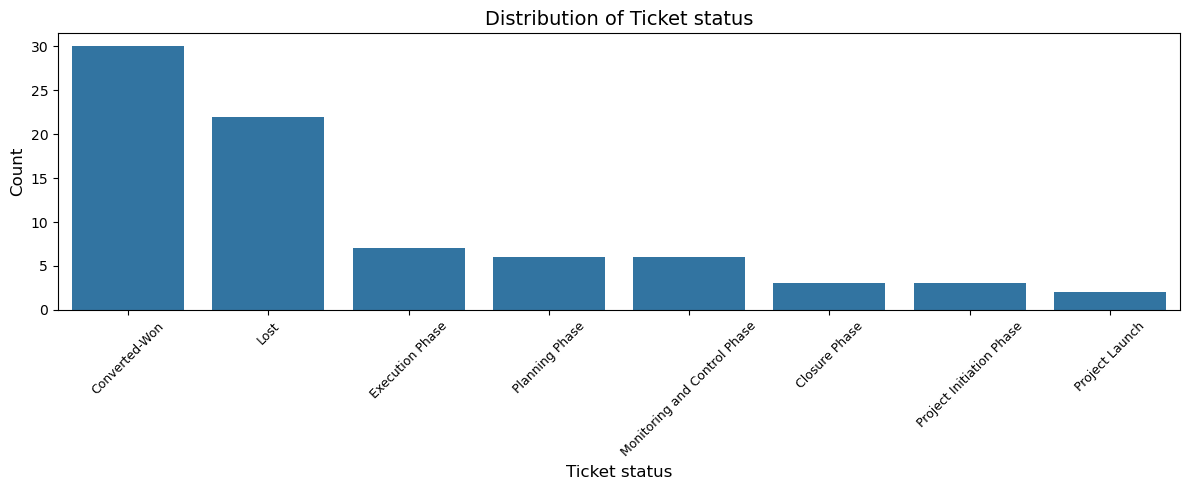

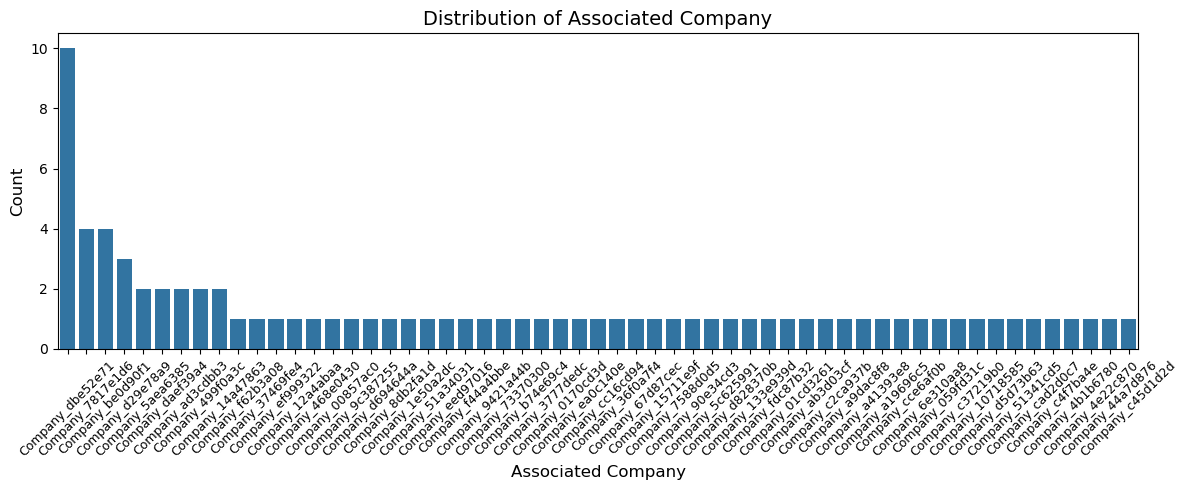

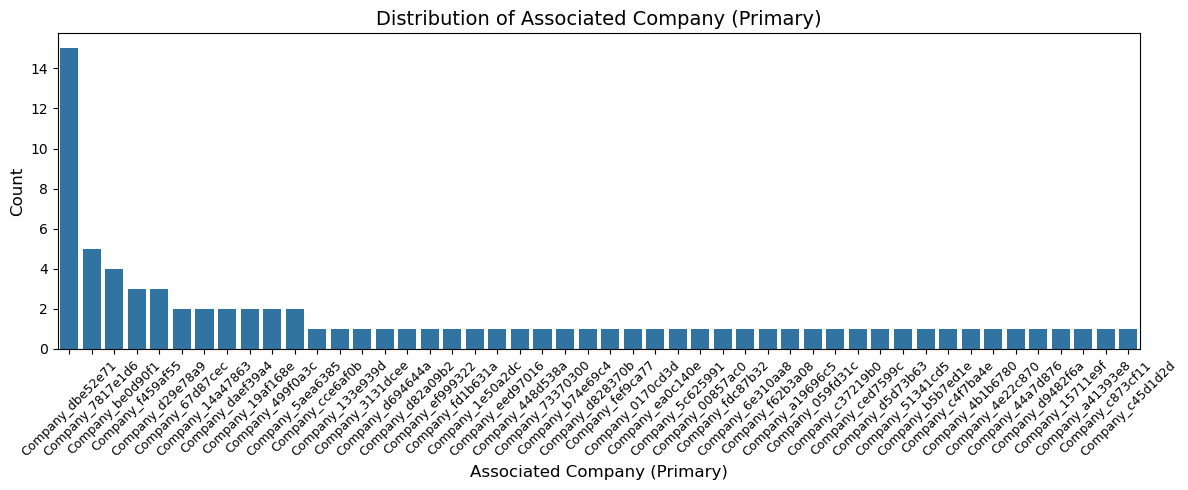

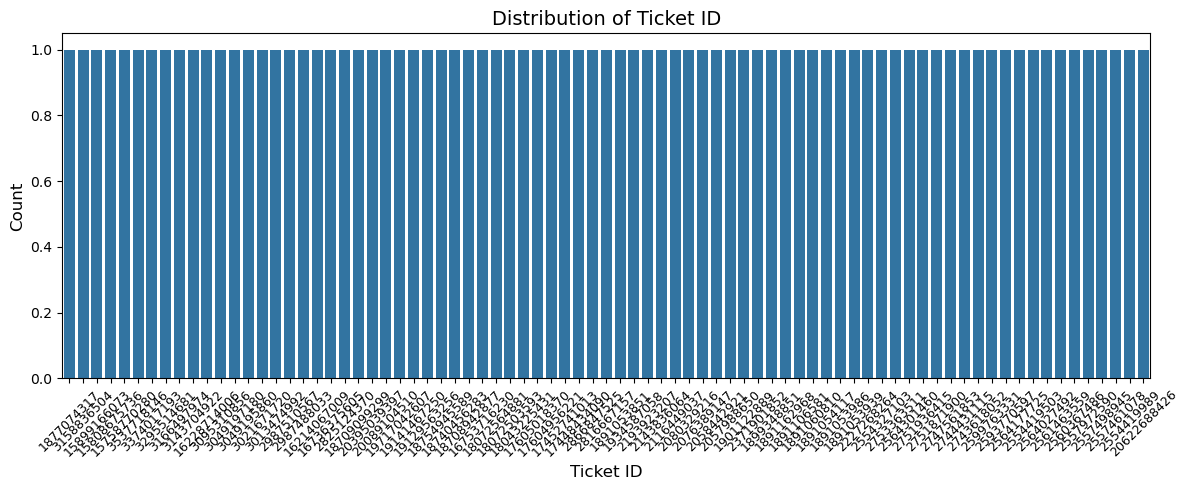

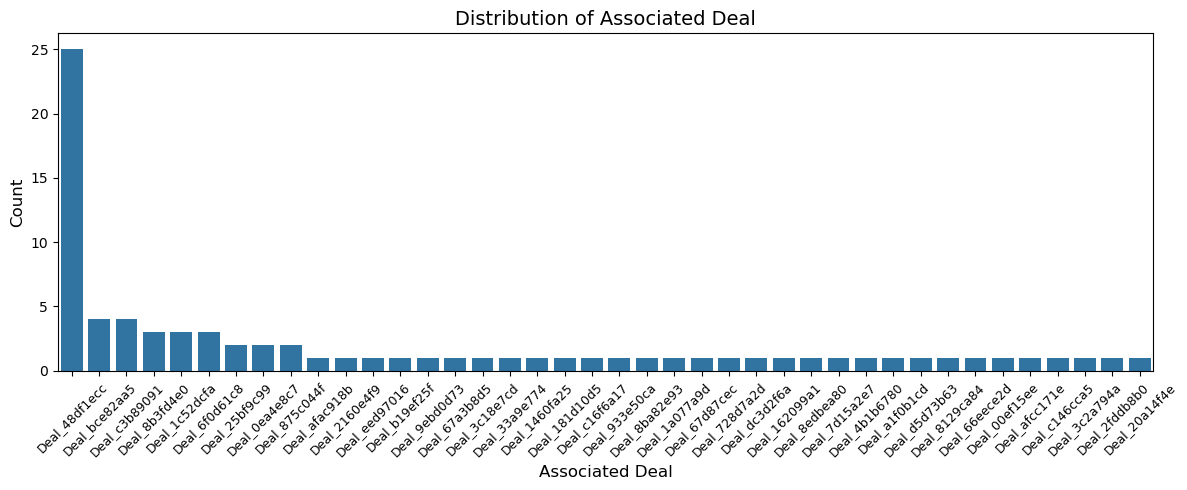

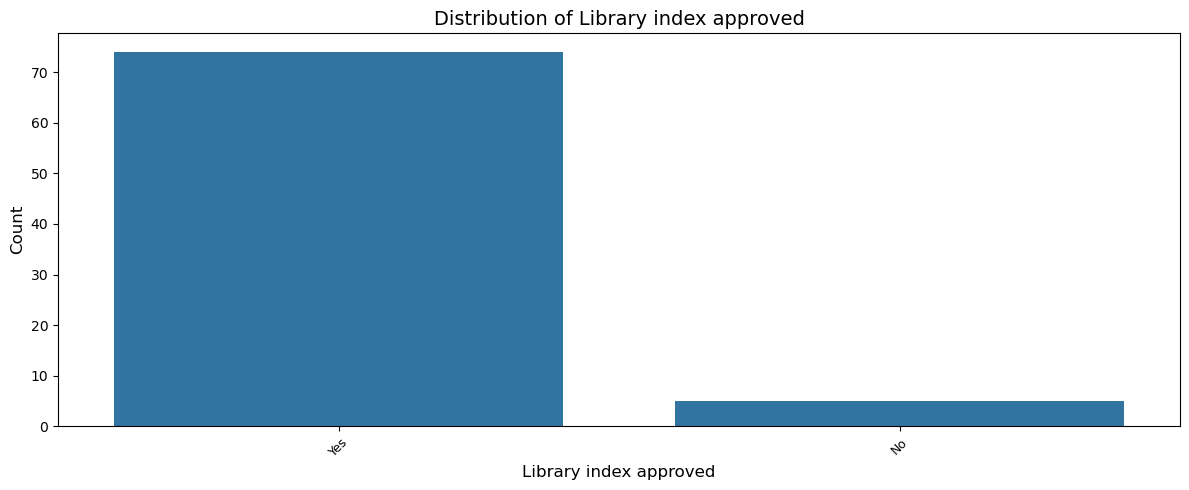

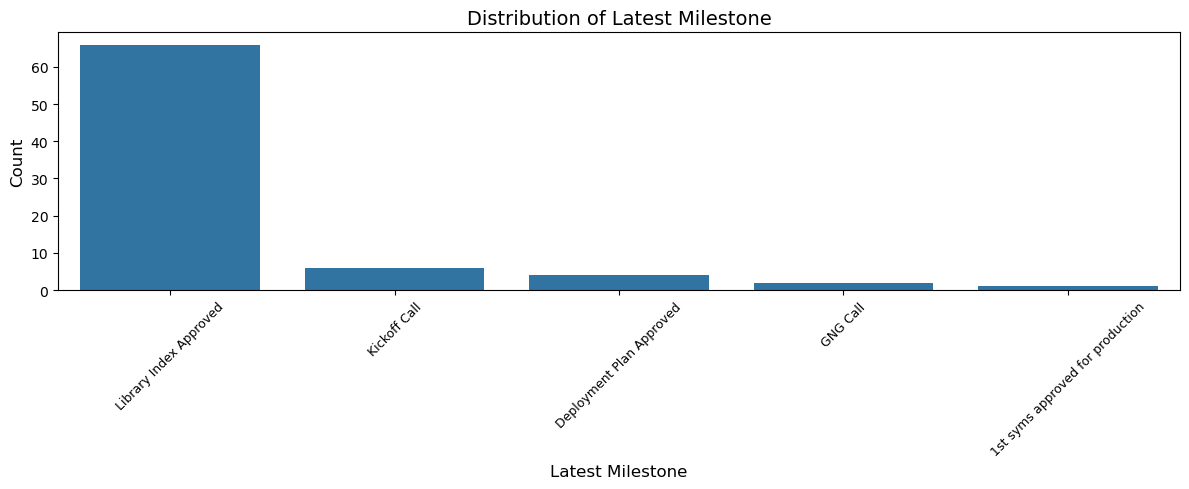

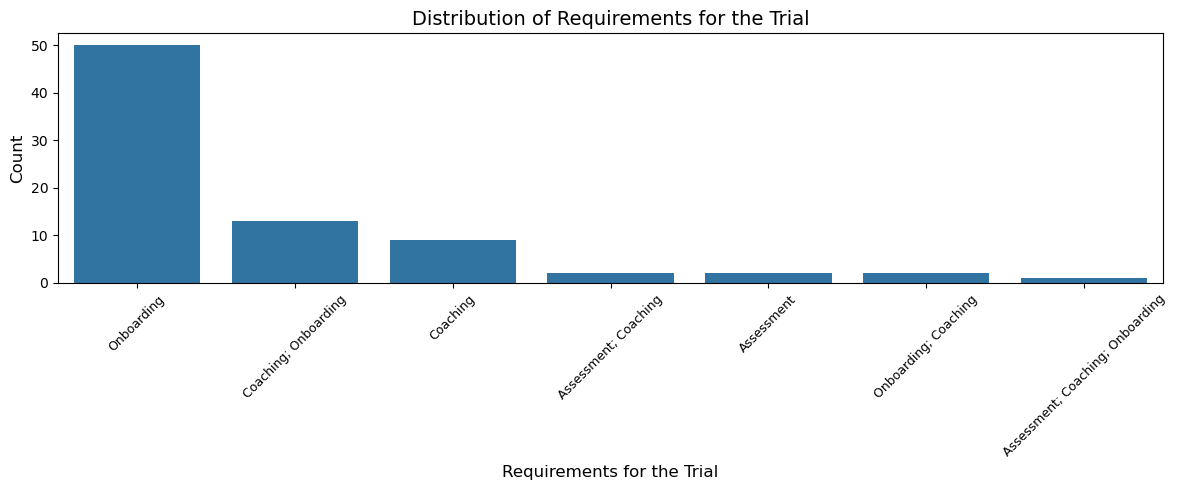

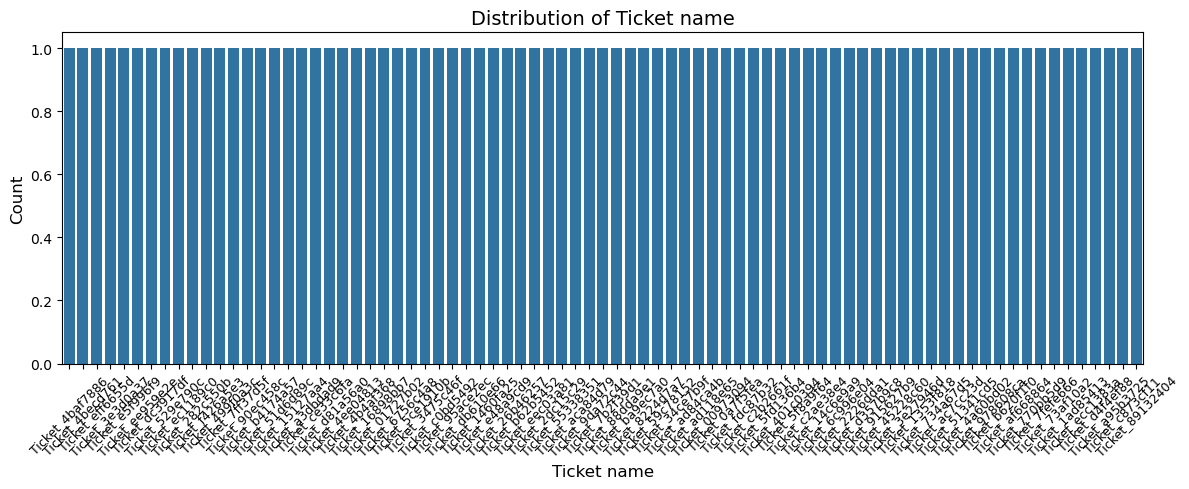

/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_61038/508097811.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


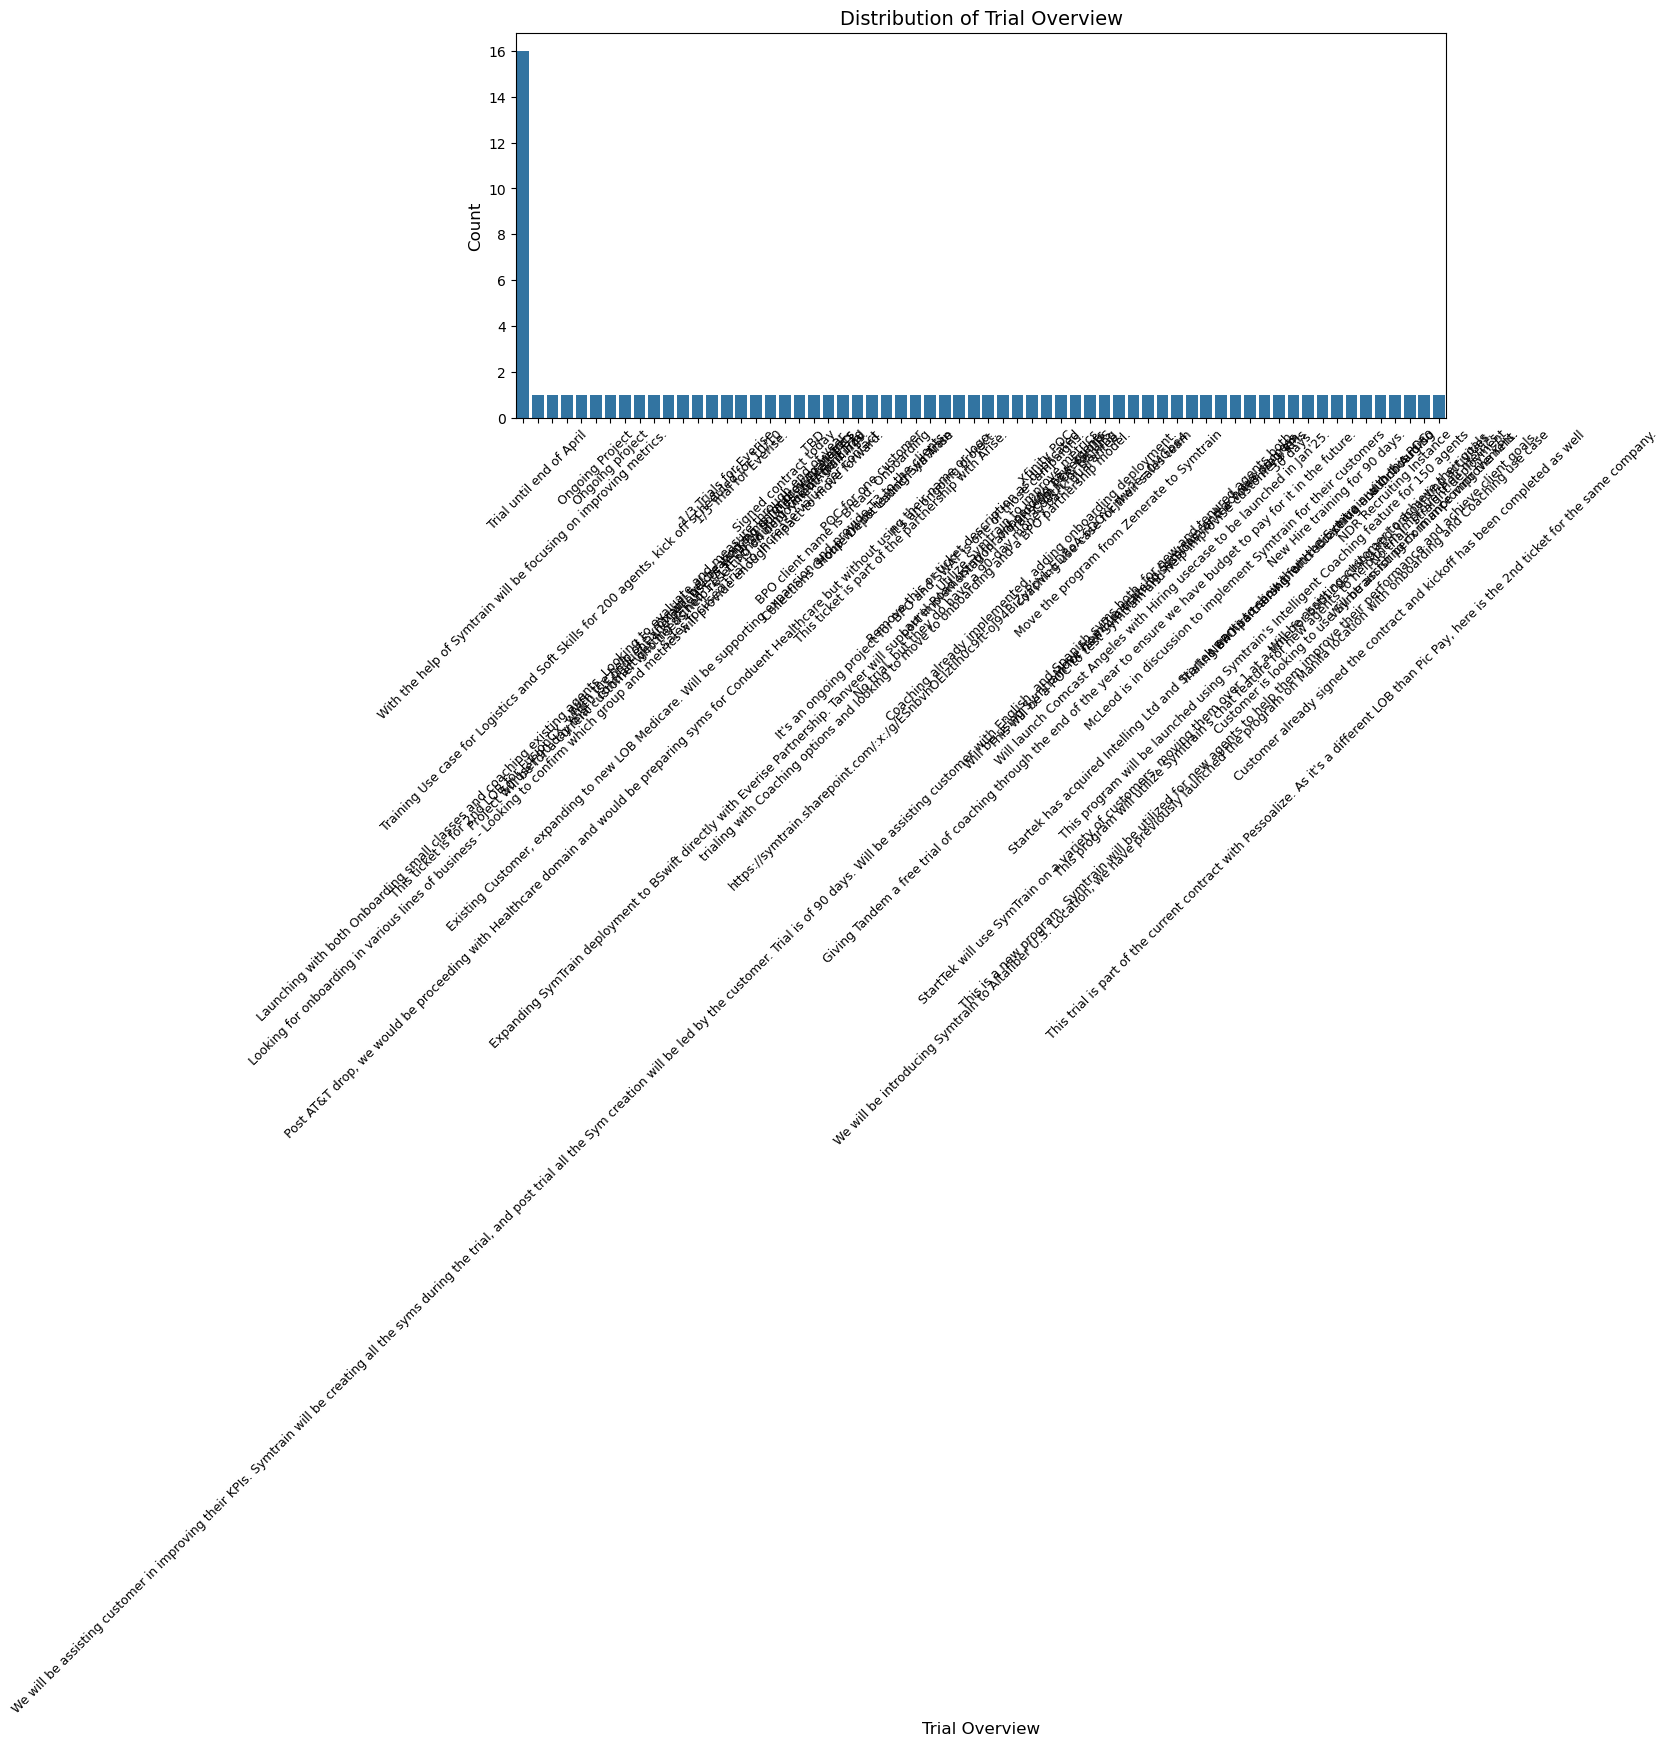

In [16]:
# Histograms for categorical variables 
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df_cleaned, x=col, order=df_cleaned[col].value_counts().index)
    plt.xticks(rotation=45, fontsize=9)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

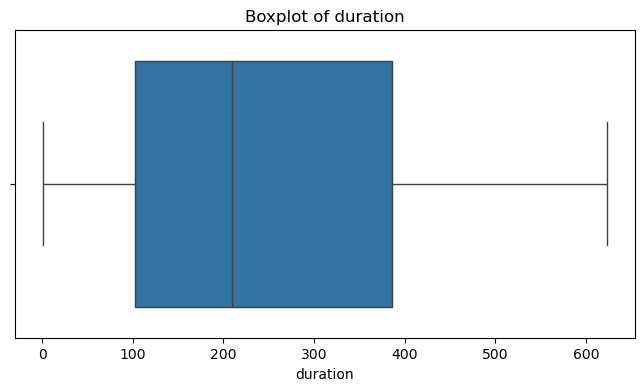

In [17]:
# Box plots
num_columns = df_cleaned.select_dtypes(include=["int64", "float64"]).columns

for col in num_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x = df_cleaned[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

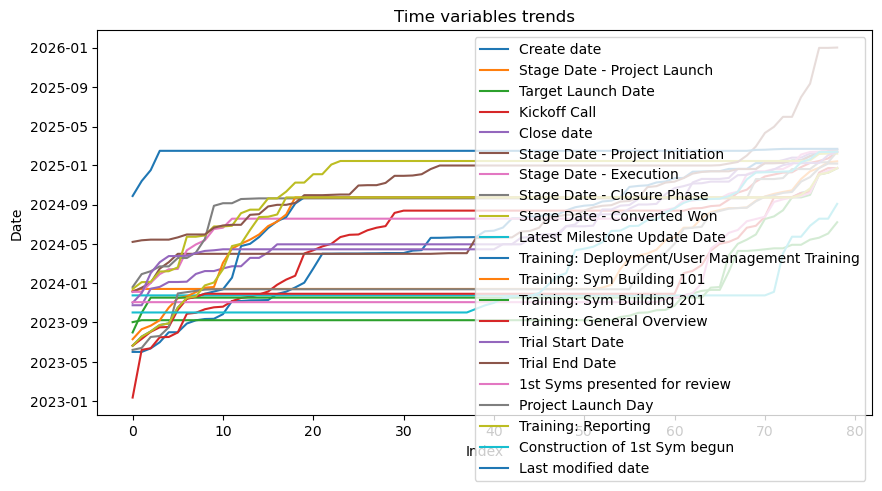

In [18]:
# Bar plots for time series data 
plt.figure(figsize=(10,5))
for col in date_cols:
    if col in df_cleaned.columns:
        df_cleaned[col].dropna().sort_values().reset_index(drop=True).plot(label=col)
plt.legend()
plt.xlabel("Index")
plt.ylabel("Date")
plt.title("Time variables trends")
plt.xticks(rotation=0)
plt.show()

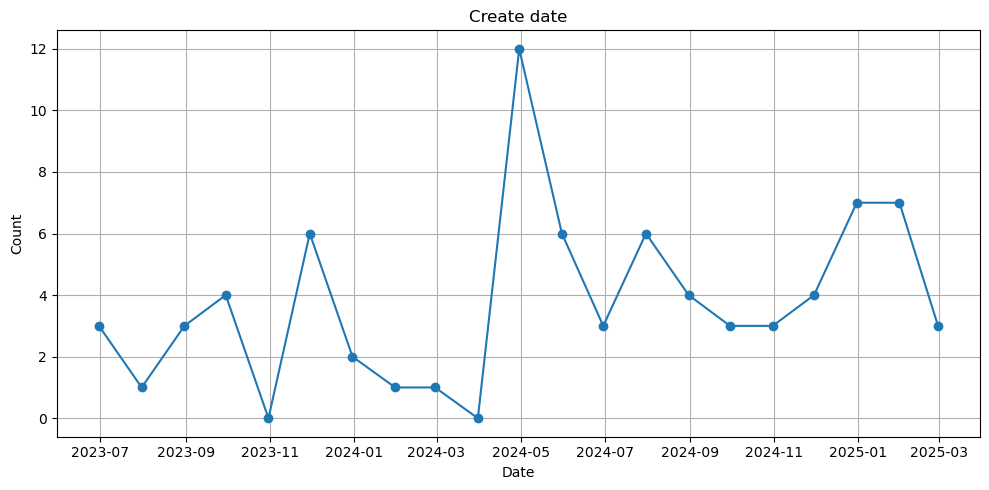

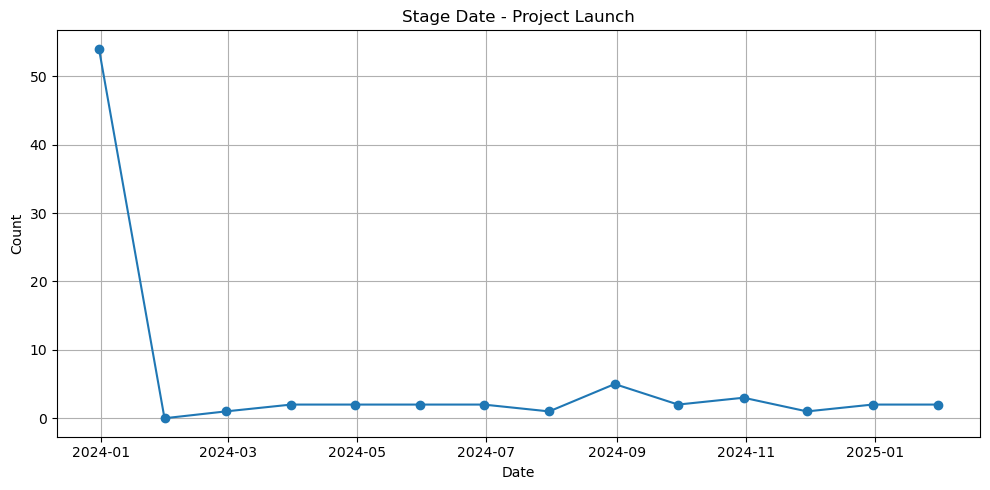

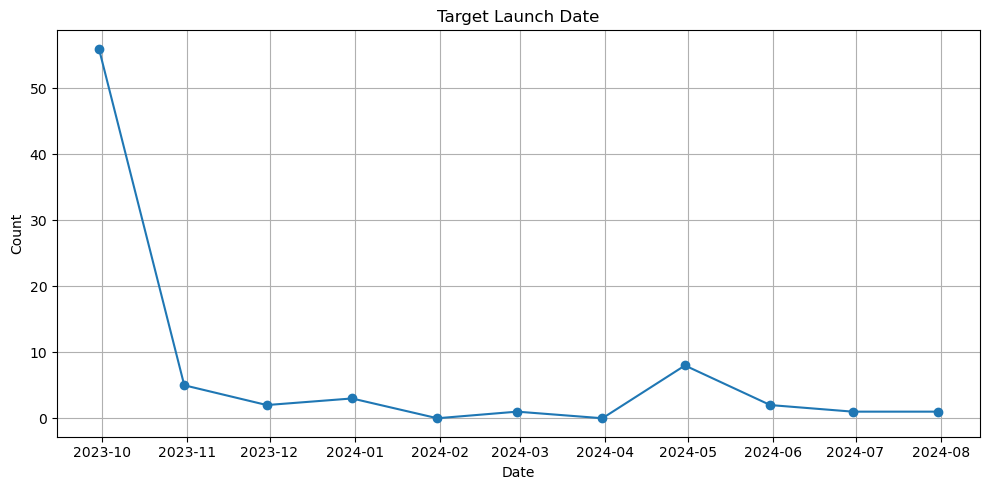

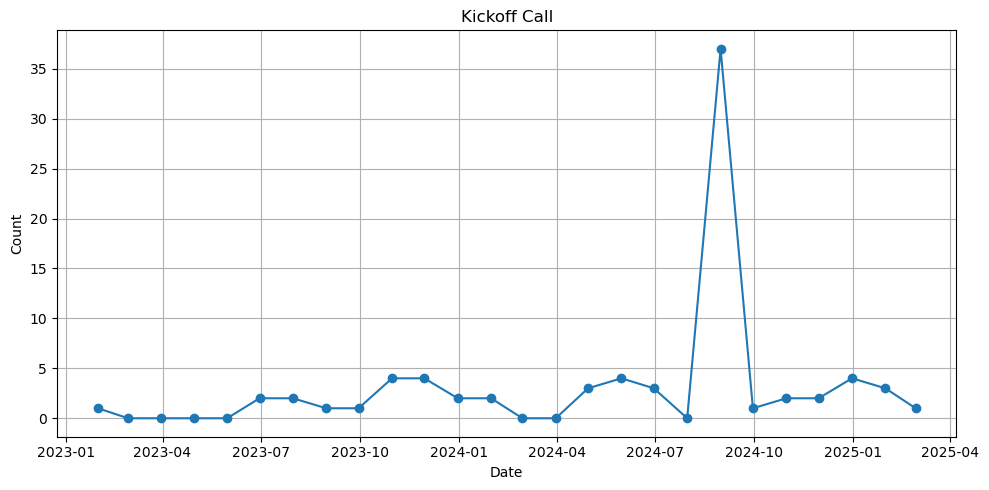

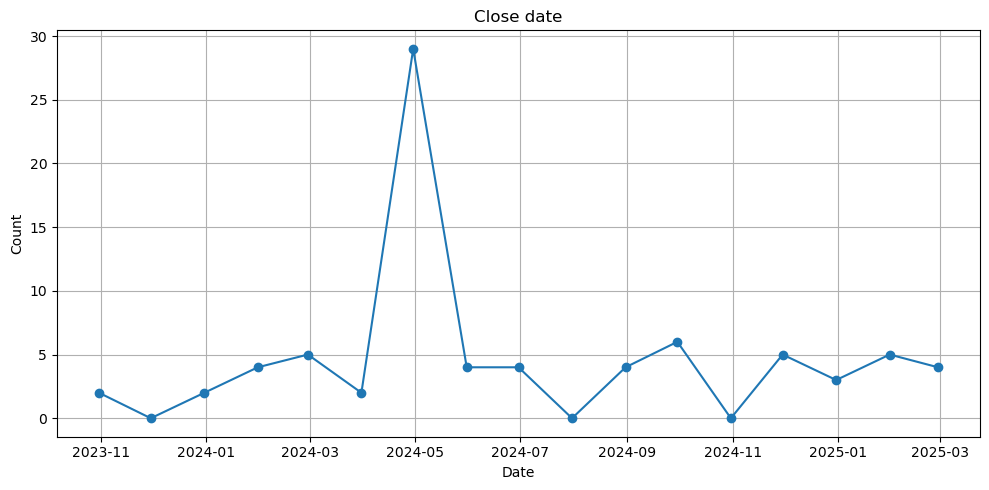

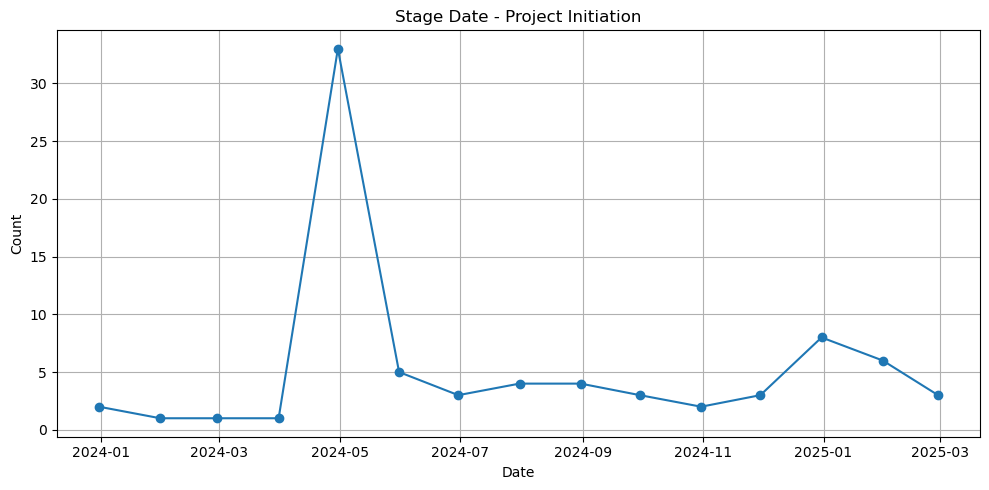

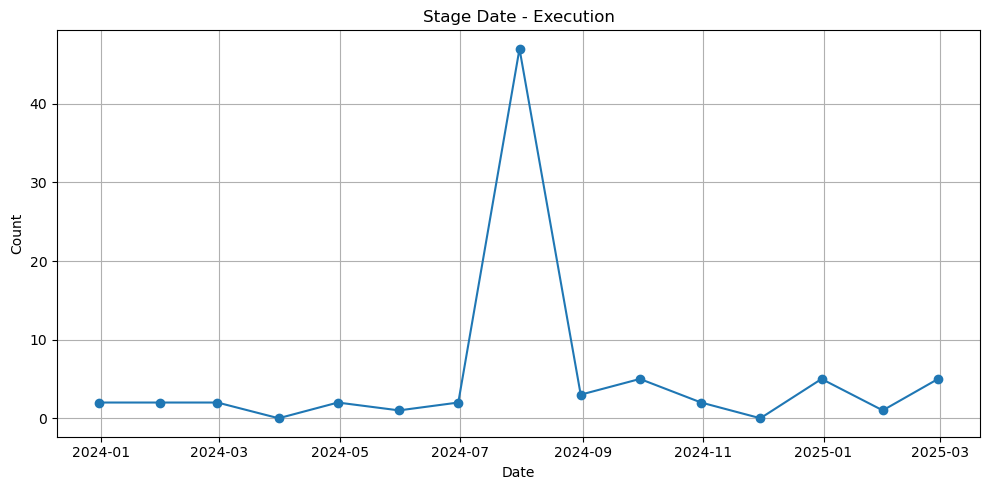

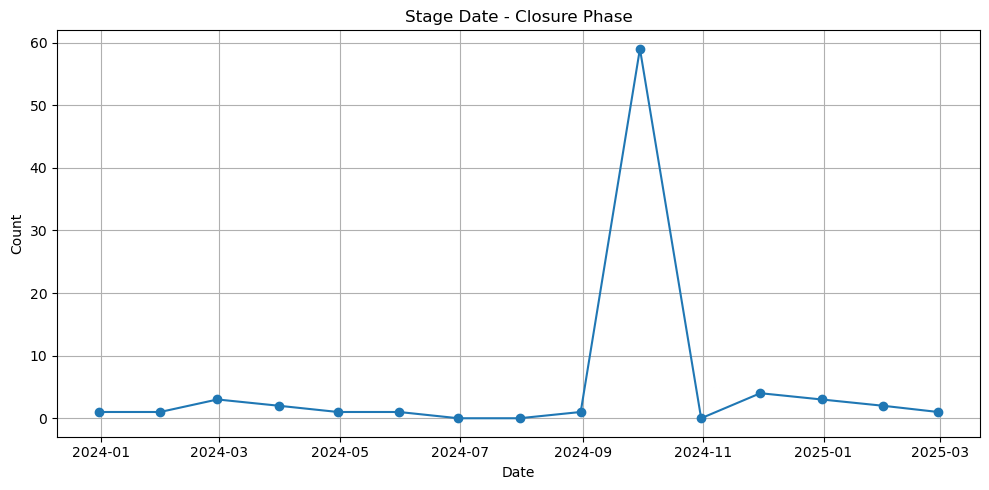

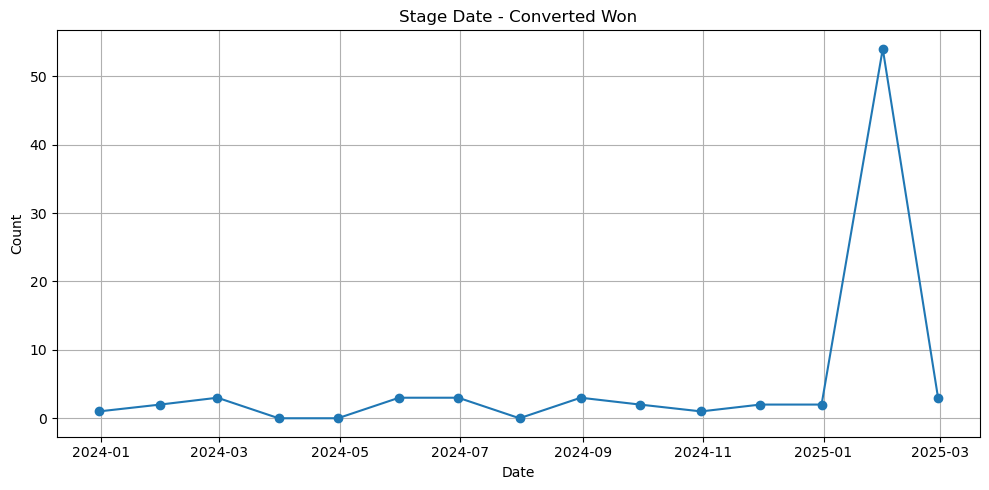

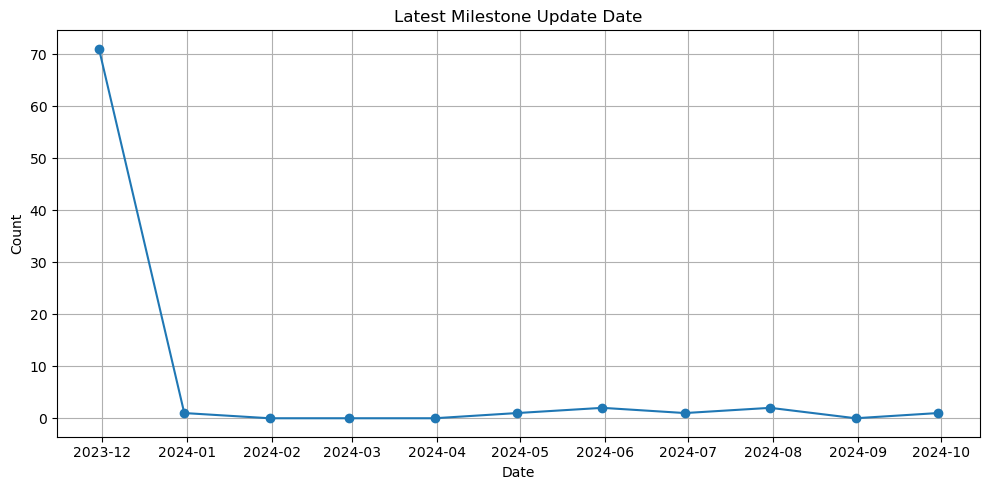

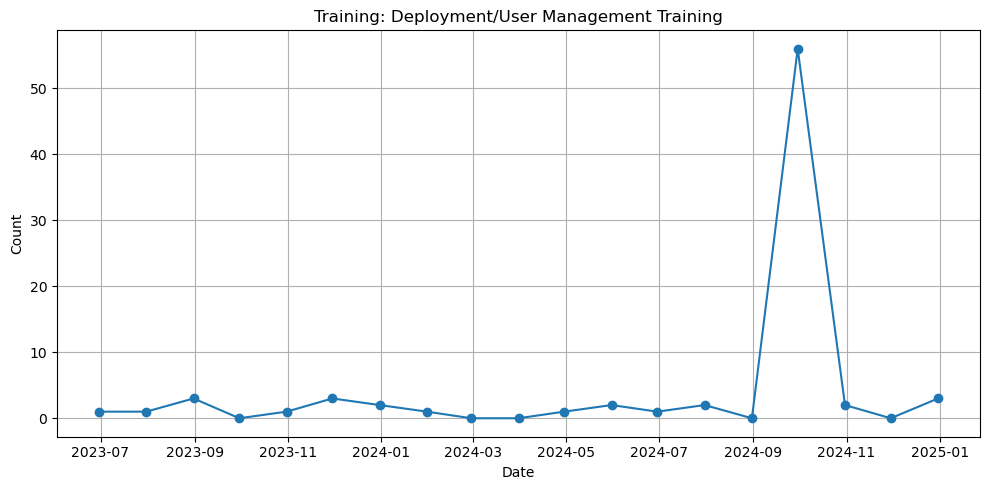

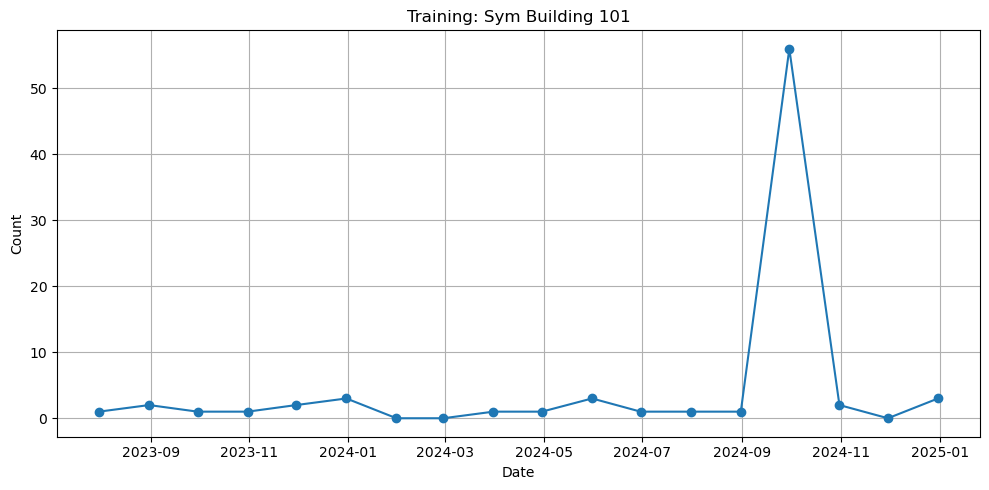

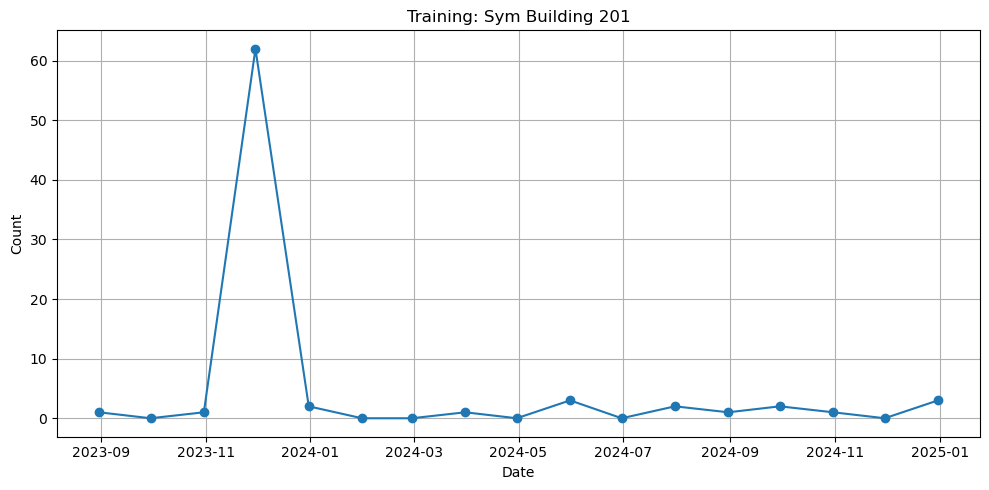

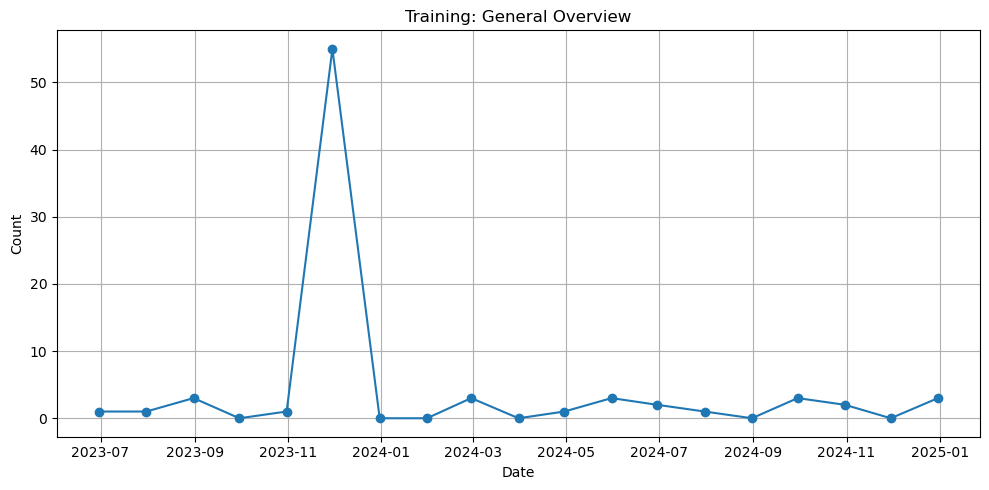

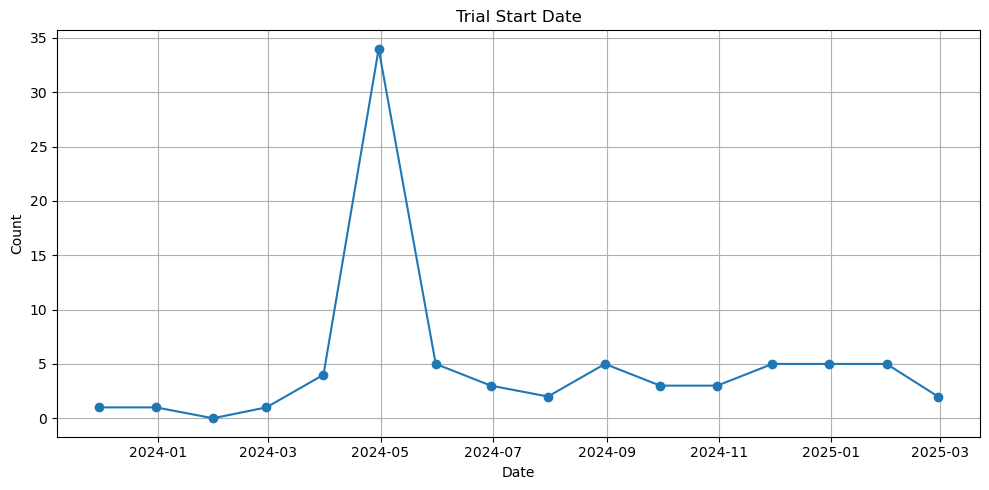

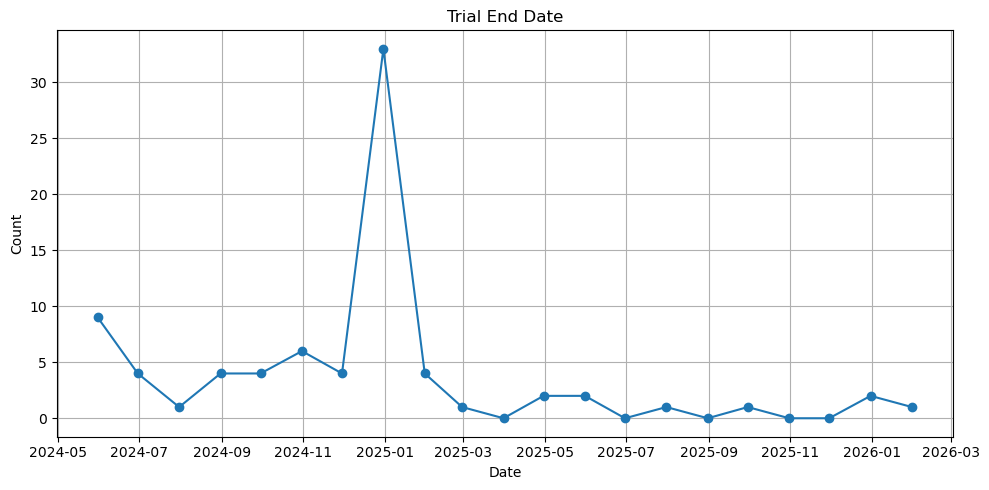

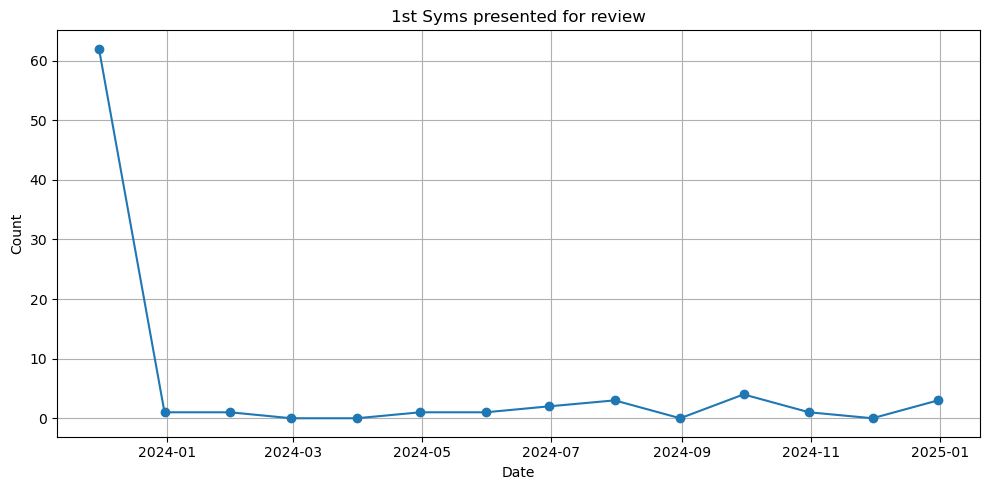

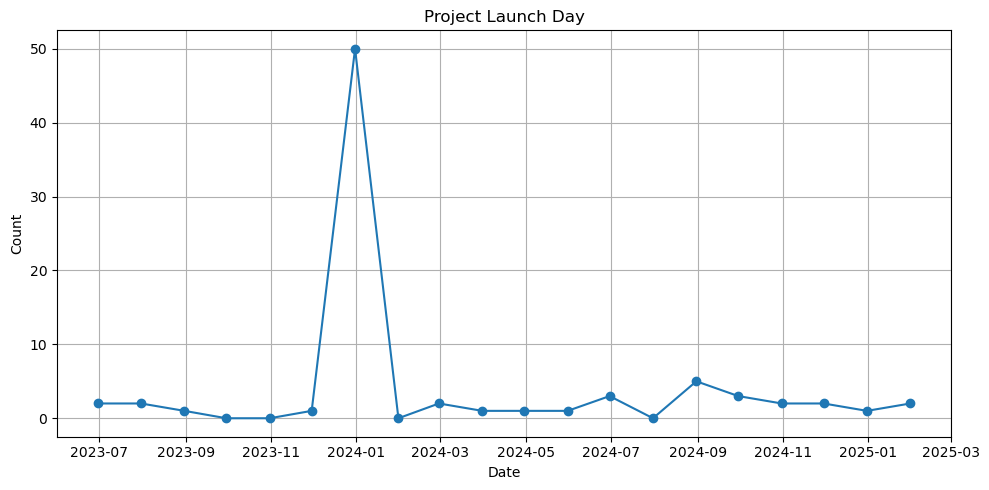

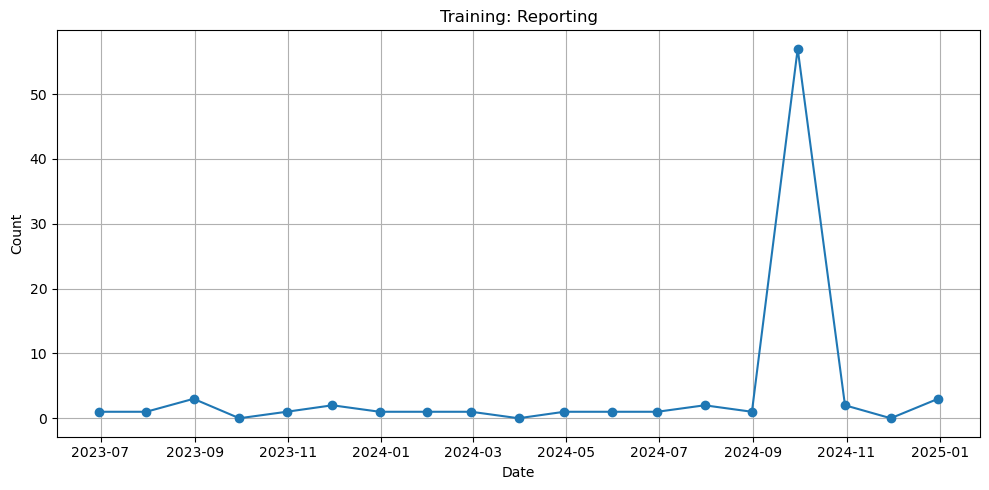

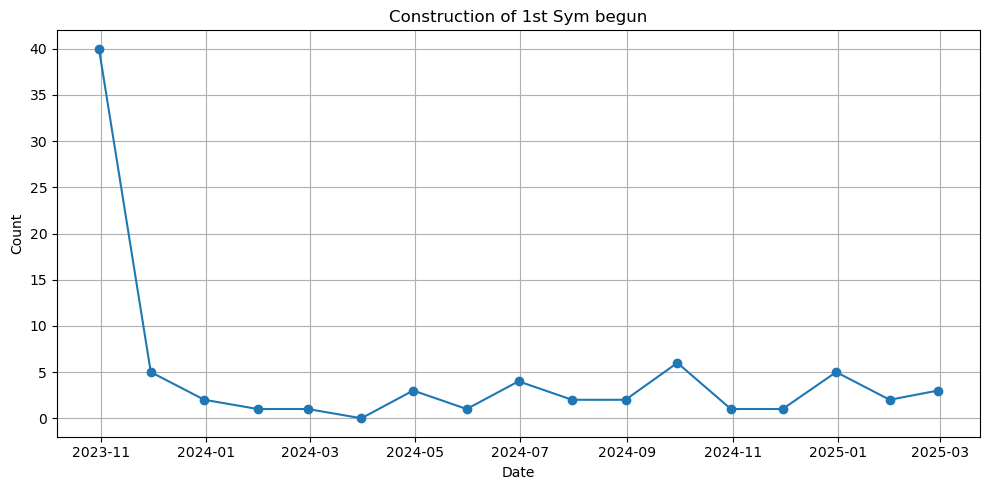

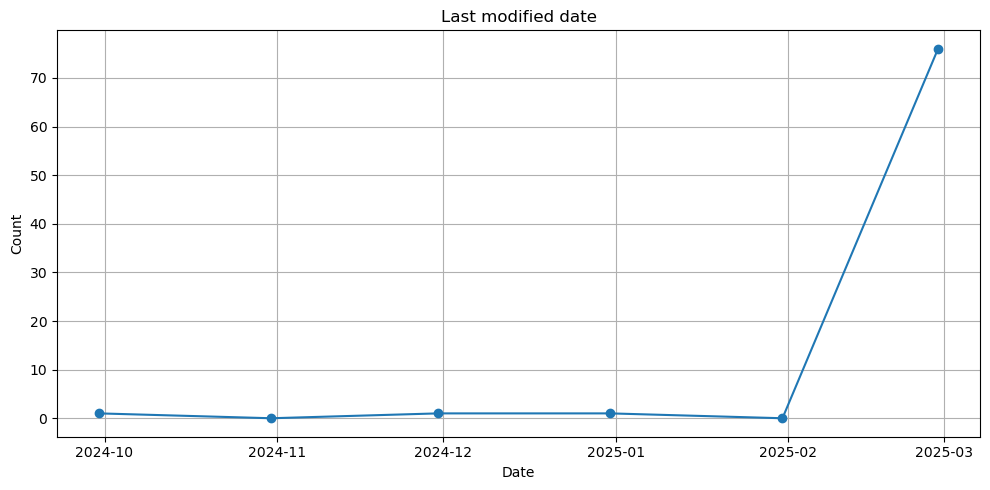

In [19]:
for col in date_cols:
    if col in df_cleaned.columns:
        company_count = df_cleaned.groupby(col).size()

        if not isinstance(company_count.index, pd.DatetimeIndex):
            company_count.index = pd.to_datetime(company_count.index, errors='coerce')
            company_count = company_count.dropna()  # Drop invalid dates

        company_count = company_count.resample('M').sum()

        plt.figure(figsize=(10, 5))
        plt.plot(company_count.index, company_count.values, marker='o')
        plt.xlabel("Date")
        plt.ylabel("Count")
        plt.title(f"{col}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [20]:
df_cleaned.to_csv("cleaned_tickets.csv", index=False)